In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
from pandas import to_datetime
import seaborn as sn
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats.stats import pearsonr, iqr

In [2]:
customer_indicators = pd.read_csv("../../indicators.csv", index_col=0)
customer_indicators

,I,Iu,spending,Imax,avg_bought,baskets,E
CustomerID,,,,,,,
12347.0,0.108021,0.059890,0.124483,0.217940,0.019291,0.031579,0.628584
12348.0,0.002658,0.003964,0.071554,0.002658,0.274122,0.000000,0.000000
12349.0,0.307641,0.311199,0.368923,0.307641,0.023277,0.000000,0.585006
12350.0,0.112957,0.073340,0.081727,0.112957,0.008866,0.000000,0.393407
12352.0,0.044423,0.037944,0.064072,0.067110,0.033188,0.031579,0.551425
...,...,...,...,...,...,...,...
18280.0,0.028571,0.048563,0.053783,0.028571,0.030539,0.000000,0.324265
18281.0,0.033223,0.023786,0.013787,0.033223,0.005147,0.000000,0.230642
18282.0,0.016279,0.021308,0.020487,0.017276,0.025711,0.005263,0.299490


In [3]:
def target_label(row):
    first_third = customer_indicators["spending"].quantile(0.33)
    second_third = customer_indicators["spending"].quantile(0.66)
    if (row["spending"] <= first_third):
        return 1
    elif (row["spending"] > first_third and row["spending"] <= second_third):
        return 2
    return 3

customer_indicators["label"] = customer_indicators.apply(target_label, axis=1)

In [4]:
from sklearn.model_selection import train_test_split

customer_indicatorsForClass=customer_indicators.copy()

#extract and remove original label values
originalLabel=customer_indicatorsForClass["label"].values
customer_indicatorsForClass=customer_indicatorsForClass.drop(columns=['label'])
#generate training and test set
train_set, test_set, train_label, test_label = train_test_split(
    customer_indicatorsForClass,
    originalLabel,
    stratify = originalLabel,
    test_size=0.40
)

In [5]:
print(train_set)
print(train_label.shape)
print(test_set)
print(test_label.shape)

                   I        Iu  spending      Imax  avg_bought   baskets  \
CustomerID                                                                 
16404.0     0.065781  0.098117  0.115670  0.065781    0.037573  0.000000   
13513.0     0.038538  0.038652  0.039421  0.038538    0.017559  0.000000   
15677.0     0.162791  0.147671  0.174485  0.162791    0.024135  0.000000   
17733.0     0.076080  0.058474  0.077564  0.112957    0.017911  0.005263   
13527.0     0.085161  0.088206  0.089257  0.141528    0.018228  0.026316   
...              ...       ...       ...       ...         ...       ...   
14085.0     0.062237  0.063429  0.055893  0.158140    0.014119  0.089474   
14964.0     0.026578  0.033697  0.022547  0.026578    0.012362  0.000000   
17148.0     0.053156  0.043608  0.037112  0.053156    0.008797  0.000000   
12603.0     0.003322  0.003964  0.037447  0.003322    0.122034  0.000000   
16141.0     0.108970  0.132805  0.170359  0.108970    0.033075  0.000000   

           

Funzione di grid search dei migliori parametri di un algoritmo:

In [6]:
from sklearn.model_selection import GridSearchCV

def grid_search(X, y, grid_params, model, jobs = 1):
    gs = GridSearchCV(
        model,
        grid_params,
        verbose = 1,
        cv = 3,
        n_jobs = 1
    )
    gs_result = gs.fit(X, y)
    return gs_result.best_score_, gs_result.best_estimator_, gs_result.best_params_

Funzione di plotting della matrice di confusione con seaborn (per il salvataggio su disco):

In [31]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    conf = confusion_matrix(y_true, y_pred)
    ax = sn.heatmap(conf, annot=True)
    ax.set(xlabel = "Predicted label", ylabel = "True label")

# K-Nearest Neighbors

Si usa l'implementazione contenuta in SciKit-Learn, validando i parametri con una grid search.

In [19]:
from sklearn.neighbors import KNeighborsClassifier

grid_params = {
    "n_neighbors": list(range(1, 10)),
    "weights": ["uniform", "distance"],
    "algorithm": ["ball_tree", "kd_tree", "brute"],
    "metric": ["euclidean", "manhattan", "minkowski"]
}

best_score, best_estimator, best_params = grid_search(
    train_set,
    train_label,
    grid_params,
    KNeighborsClassifier()
)
display(best_score)
display(best_estimator)
display(best_params)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 486 out of 486 | elapsed:   17.7s finished


0.8966160265263428

KNeighborsClassifier(algorithm='ball_tree', metric='manhattan',
                     weights='distance')

{'algorithm': 'ball_tree',
 'metric': 'manhattan',
 'n_neighbors': 5,
 'weights': 'distance'}

Usiamo i parametri trovati per eseguire il training sull'intero training set e la predizione dei risultati

In [20]:
knn = KNeighborsClassifier(**best_params)
knn.fit(train_set, train_label)
pred_label = knn.predict(test_set)

Verifichiamo i risultati attraverso la matrice di confusione:

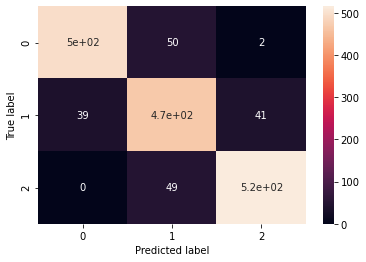

In [33]:
plot_confusion_matrix(test_label, pred_label)


Facciamo restituire un report della precisione, del recall e dello f1-score:

In [38]:
from sklearn.metrics import classification_report

print(classification_report(test_label, pred_label))

              precision    recall  f1-score   support

           1       0.93      0.90      0.92       547
           2       0.83      0.85      0.84       547
           3       0.92      0.91      0.92       564

    accuracy                           0.89      1658
   macro avg       0.89      0.89      0.89      1658
weighted avg       0.89      0.89      0.89      1658



# Support Vector Machine

Esistono molte implementazioni di Support Vector Machine dedicate a problemi di classificazione. 

## Support Vector Classification (`SVC`)

In [51]:
from sklearn.svm import SVC

C_values = [2**(i) for i in range(-5, 15, 2)]

gamma_values = [2**(i) for i in range(-15, 3, 2)] + ["auto", "scale"]

grid_params = {
    "kernel": ["poly", "rbf", "sigmoid", "linear"],
    "C": C_values,
    "gamma": gamma_values,
    "shrinking": [True, False]
}

best_score, best_estimator, best_params = grid_search(
    train_set,
    train_label,
    grid_params,
    SVC()
)
display(best_score)
display(best_estimator)
display(best_params)

Fitting 3 folds for each of 880 candidates, totalling 2640 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2640 out of 2640 | elapsed:  4.4min finished


0.9939662088269628

SVC(C=8192, gamma=3.0517578125e-05, kernel='linear')

{'C': 8192, 'gamma': 3.0517578125e-05, 'kernel': 'linear', 'shrinking': True}

Si indaga ulteriormente con un'altra 3-fold validation con C che varia da 2^12 a 2^13 e con gamma che varia da 

In [61]:
from sklearn.svm import SVC

C_values = np.linspace(2**12, 2**13, 11)

gamma_values = list(np.linspace(2**(-15), 2**(-14), 11)) + ["auto", "scale"]

grid_params = {
    "kernel": ["poly", "rbf", "sigmoid", "linear"],
    "C": C_values,
    "gamma": gamma_values,
    "shrinking": [True, False]
}

best_score, best_estimator, best_params = grid_search(
    train_set,
    train_label,
    grid_params,
    SVC()
)
display(best_score)
display(best_estimator)
display(best_params)

Fitting 3 folds for each of 1144 candidates, totalling 3432 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3432 out of 3432 | elapsed: 10.9min finished


0.9939662088269628

SVC(C=7372.8, gamma=3.0517578125e-05, kernel='linear')

{'C': 7372.8, 'gamma': 3.0517578125e-05, 'kernel': 'linear', 'shrinking': True}

In [56]:
svc = SVC(**best_params)
svc.fit(train_set, train_label)
pred_label = svc.predict(test_set)

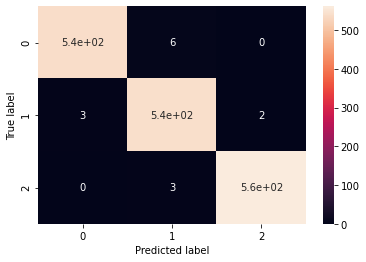

In [58]:
plot_confusion_matrix(test_label, pred_label)
plt.savefig("./svc-conf.png")

## New Support Vector Classification (`NuSVC`)


## Linear Support Vector Classification (`LinearSVC`)